In [1]:
# Functions for recall, precision and f1 score
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


In [2]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('val_acc')>0.99) and (logs.get('acc')>0.99) and (logs.get('val_loss')<1e-10) and (logs.get('loss')<1e-10):
      print("\nReached perfect accuracy so cancelling training!")
      self.model.stop_training = True

epoch_schedule = myCallback()

In [3]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os

In [4]:
def load_A0_images(df,pathA0):
    imagesA0 = []
    df = pd.DataFrame(df)
    for i in df.index.values:
        base = os.path.sep.join([pathA0, "{}_CgA0.png".format(i + 1)]) # for S0 images --> "{}_CgS0.png"
        #print(base)
        image = cv2.imread(base,0) # read the path using opencv
        image = cv2.resize(image, (128, 128))
        #plt.imshow(image) # use matplotlib to plot the image
        image = image[:,:,np.newaxis] #This is convert (600,600) --> (600,600,1)
        imagesA0.append(image) 
    return np.array(imagesA0)

In [5]:
def load_S0_images(df,pathS0):
    imagesS0 = []
    df = pd.DataFrame(df)
    for j in df.index.values:
        base2 = os.path.sep.join([pathS0, "{}_CgS0.png".format(j + 1)]) # for S0 images --> "{}_CgS0.png"
        #print(base)
        image2 = cv2.imread(base2,0) # read the path using opencv
        image2 = cv2.resize(image2, (128, 128))
        #plt.imshow(image2) # use matplotlib to plot the image
        image2 = image2[:,:,np.newaxis] #This is convert (600,600) --> (600,600,1)
        imagesS0.append(image2) 
    return np.array(imagesS0)

In [6]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import LeakyReLU
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

def create_cnn(width, height, depth, filters=(16, 32, 64)):
	# initialize the input shape and channel dimension, assuming
	# TensorFlow/channels-last ordering
	inputShape = (height, width, depth)
	chanDim = -1

	# define the model input
	inputs = Input(shape=inputShape)

	# loop over the number of filters
	for (i, f) in enumerate(filters):
		# if this is the first CONV layer then set the input
		# appropriately
		if i == 0:
			x = inputs

		# CONV => RELU => BN => POOL
		x = Conv2D(f, (3, 3), padding="same")(x)
		x = LeakyReLU(alpha=0.3)(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)

	# flatten the volume, then FC => RELU => BN => DROPOUT
	x = Flatten()(x)

	# construct the CNN
	model = Model(inputs, x)

	# return the CNN
	return model

In [7]:
# import the necessary packages
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import concatenate
import numpy as np
import argparse
import locale
import os

# LABELS
# uni = 0
# cross = 1
# quasi = 2
mclass = 100
y1 = np.zeros((mclass,1), dtype=int)
y2 = np.ones((mclass,1), dtype=int)
y3 = y2*2

# LOCATION on input images

# unidirectional layup
pathA0uni = 'E:/PhD-MSR/material_characterization_forJournal/DispersionCalculatorCode/PropagationAngleProfiler_3/StoreResults/GroupVelPolarPlots/BWPolarRep/DCmaterials/uni/A0'
pathS0uni = 'E:/PhD-MSR/material_characterization_forJournal/DispersionCalculatorCode/PropagationAngleProfiler_3/StoreResults/GroupVelPolarPlots/BWPolarRep/DCmaterials/uni/S0'

# crossply layup
pathA0cross = 'E:/PhD-MSR/material_characterization_forJournal/DispersionCalculatorCode/PropagationAngleProfiler_3/StoreResults/GroupVelPolarPlots/BWPolarRep/DCmaterials/cross/A0'
pathS0cross = 'E:/PhD-MSR/material_characterization_forJournal/DispersionCalculatorCode/PropagationAngleProfiler_3/StoreResults/GroupVelPolarPlots/BWPolarRep/DCmaterials/cross/S0'

# quasi-isotropic layup
pathA0quasi = 'E:/PhD-MSR/material_characterization_forJournal/DispersionCalculatorCode/PropagationAngleProfiler_3/StoreResults/GroupVelPolarPlots/BWPolarRep/DCmaterials/quasi/A0'
pathS0quasi = 'E:/PhD-MSR/material_characterization_forJournal/DispersionCalculatorCode/PropagationAngleProfiler_3/StoreResults/GroupVelPolarPlots/BWPolarRep/DCmaterials/quasi/S0'

In [8]:
# load the house im and then scale the pixel intensities to the
# range [0, 1]
print("[INFO] loading A0 images...")
imagesA0uni = load_A0_images(y1, pathA0uni)
imagesA0cross = load_A0_images(y2, pathA0cross)
imagesA0quasi = load_A0_images(y3, pathA0quasi)
imagesA0 = np.concatenate([imagesA0uni,imagesA0cross,imagesA0quasi], axis = 0)
imagesA0 = imagesA0 / 255.0
print(imagesA0.shape)

print("[INFO] loading S0 images...")
imagesS0uni = load_S0_images(y1, pathS0uni)
imagesS0cross = load_S0_images(y2, pathS0cross)
imagesS0quasi = load_S0_images(y3, pathS0quasi)
imagesS0 = np.concatenate([imagesS0uni,imagesS0cross,imagesS0quasi], axis = 0)
imagesS0 = imagesS0 / 255.0
print(imagesS0.shape)

[INFO] loading A0 images...
(300, 128, 128, 1)
[INFO] loading S0 images...
(300, 128, 128, 1)


In [9]:
# finalize the lables
from keras.utils import to_categorical

y = np.concatenate([y1,y2,y3], axis=0)
y = np.array(y)
df = to_categorical(y)
print(df.shape)

(300, 3)


In [10]:
# random no. generator for random_state in train_test_split
import random
randno = random.randint(0, 42)
print(randno)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing

# split A0
splitA0= train_test_split(df, imagesA0, test_size=0.10, random_state=randno)
(trainY1, testY1, trainImagesX1, testImagesX1) = splitA0

# split S0
splitS0= train_test_split(df, imagesS0, test_size=0.10, random_state=randno)
(trainY2, testY2, trainImagesX2, testImagesX2) = splitS0

7


In [11]:
# print(trainY1), print(trainY2) and print(trainY3) should yield same values
print(trainY1)

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0.

In [12]:
# create the MLP and CNN models
cnn1 = create_cnn(128,128,1)
cnn2 = create_cnn(128,128,1)

# create the input to our final set of layers as the *output* of both
combinedInput = concatenate([cnn1.output,cnn2.output])

# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(16, activation="relu")(combinedInput)
#x = Dense(32, activation="relu")(x)
# x = Dropout(0.025)(x)
x = Dense(3, activation="softmax")(x)

# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[cnn1.input,cnn2.input], outputs=x)

# compile the model using mean absolute percentage error as our loss,
# implying that we seek to minimize the absolute percentage difference
# between our price *predictions* and the *actual prices*
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics = ['acc',precision_m,recall_m])

In [13]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 128, 128, 16) 160         input_2[0][0]                    
____________________________________________________________________________________________

In [14]:
print("Training images in A0...",trainImagesX1.shape)
print("Training images in S0...",trainImagesX2.shape)
trainImages = trainImagesX1.shape[0]+trainImagesX2.shape[0]
print("Overall training examples...",trainImages)
print("Test images in A0...",testImagesX1.shape)
print("Test images in S0...",testImagesX2.shape)
testImages = testImagesX1.shape[0]+testImagesX2.shape[0]
print("Overall training examples...",testImages)
print("Training labels..",trainY1.shape)
print("Test labels..",testY1.shape)

Training images in A0... (270, 128, 128, 1)
Training images in S0... (270, 128, 128, 1)
Overall training examples... 540
Test images in A0... (30, 128, 128, 1)
Test images in S0... (30, 128, 128, 1)
Overall training examples... 60
Training labels.. (270, 3)
Test labels.. (30, 3)


In [15]:
X = [trainImagesX1,trainImagesX2]
np.array(X).shape

(2, 270, 128, 128, 1)

In [16]:
# train the model
print("[INFO] training model...")
history1 = model.fit([trainImagesX1,trainImagesX2],trainY1,\
                     validation_data=([testImagesX1,testImagesX2],testY1),\
                     epochs=250, batch_size=4, verbose = 2, callbacks = [epoch_schedule])

[INFO] training model...
Train on 270 samples, validate on 30 samples
Epoch 1/250
 - 19s - loss: 1.0942 - acc: 0.9000 - precision_m: 0.9044 - recall_m: 0.9007 - val_loss: 0.7081 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 0.4375
Epoch 2/250
 - 1s - loss: 6.8267e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.6992 - val_acc: 0.4333 - val_precision_m: 0.5312 - val_recall_m: 0.3125
Epoch 3/250
 - 6s - loss: 3.3001e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.5589 - val_acc: 0.6000 - val_precision_m: 0.6562 - val_recall_m: 0.5000
Epoch 4/250
 - 6s - loss: 2.2157e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.3213 - val_acc: 0.8667 - val_precision_m: 0.8750 - val_recall_m: 0.8750
Epoch 5/250
 - 1s - loss: 1.4298e-04 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.1399 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 6/250
 - 6s - loss: 1.0471e-04 - acc:

Epoch 46/250
 - 6s - loss: 2.7347e-06 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 3.5325e-06 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 47/250
 - 6s - loss: 2.5802e-06 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 3.3537e-06 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 48/250
 - 1s - loss: 2.7113e-06 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 3.2027e-06 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 49/250
 - 6s - loss: 2.4296e-06 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 3.0875e-06 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 50/250
 - 6s - loss: 2.3347e-06 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 2.9484e-06 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 51/250
 - 1s - loss: 2.1365e-06 - acc: 1.0000 - precision_m: 1.0000 - recall_m:

Epoch 91/250
 - 1s - loss: 5.3909e-07 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 6.0797e-07 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 92/250
 - 6s - loss: 5.2849e-07 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 5.8015e-07 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 93/250
 - 6s - loss: 5.3688e-07 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 5.7220e-07 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 94/250
 - 6s - loss: 4.7507e-07 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 5.4439e-07 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 95/250
 - 1s - loss: 4.7684e-07 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 5.2452e-07 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 96/250
 - 6s - loss: 4.6580e-07 - acc: 1.0000 - precision_m: 1.0000 - recall_m:

Epoch 136/250
 - 6s - loss: 1.4923e-07 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 1.5100e-07 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 137/250
 - 1s - loss: 1.9471e-07 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 1.4305e-07 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 138/250
 - 6s - loss: 1.3775e-07 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 1.4702e-07 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 139/250
 - 6s - loss: 1.1303e-07 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 1.3908e-07 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 140/250
 - 6s - loss: 1.3025e-07 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 1.2716e-07 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 141/250
 - 1s - loss: 1.1568e-07 - acc: 1.0000 - precision_m: 1.0000 - rec

Epoch 181/250
 - 6s - loss: 3.9295e-08 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 2.7815e-08 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 182/250
 - 6s - loss: 3.9736e-08 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 2.7815e-08 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 183/250
 - 1s - loss: 2.7374e-08 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 2.3842e-08 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 184/250
 - 6s - loss: 3.0023e-08 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 2.3842e-08 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 185/250
 - 6s - loss: 2.6491e-08 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 2.3842e-08 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 186/250
 - 6s - loss: 2.8257e-08 - acc: 1.0000 - precision_m: 1.0000 - rec

Epoch 226/250
 - 1s - loss: 6.6227e-09 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 7.9473e-09 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 227/250
 - 6s - loss: 5.7397e-09 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 7.9473e-09 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 228/250
 - 6s - loss: 6.1812e-09 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 7.9473e-09 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 229/250
 - 1s - loss: 7.9473e-09 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 7.9473e-09 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 230/250
 - 6s - loss: 6.1812e-09 - acc: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 3.9736e-09 - val_acc: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 231/250
 - 6s - loss: 6.1812e-09 - acc: 1.0000 - precision_m: 1.0000 - rec

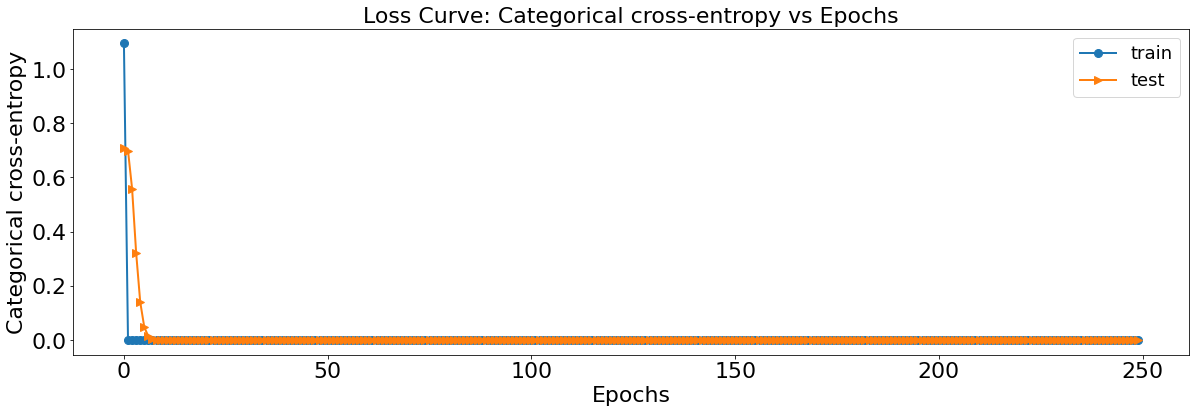

In [17]:
# Summarize history for loss = cross-entropy
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.plot(history1.history['loss'],'-o',linewidth=2, markersize=8)
plt.plot(history1.history['val_loss'],'->',linewidth=2, markersize=8)
plt.title('Loss Curve: Categorical cross-entropy vs Epochs',fontsize=22)
plt.ylabel('Categorical cross-entropy',fontsize=22)
#plt.grid()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Epochs',fontsize=22)
plt.legend(['train', 'test'], loc='upper right',fontsize=18)
#plt.axis([0,250,1e-6,1e-10])
plt.savefig("CCE1.jpg", dpi=600)
plt.show()

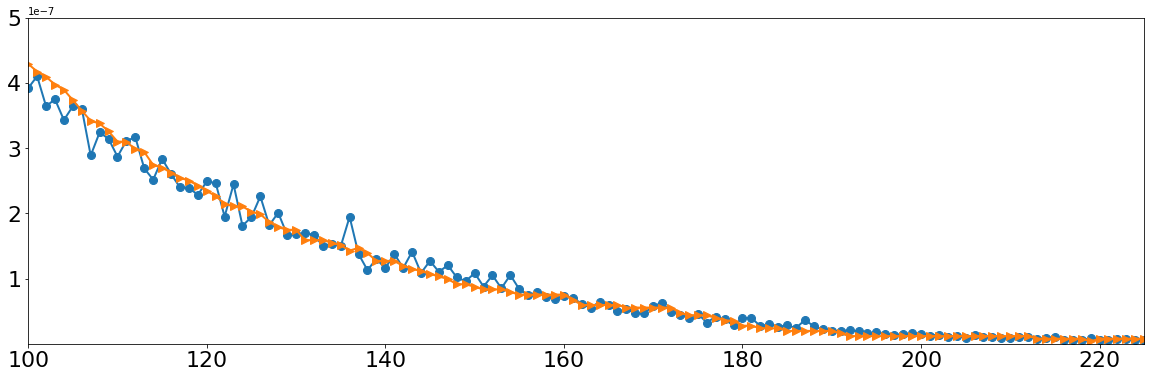

In [21]:
# Summarize history for loss = CCE
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.plot(history1.history['loss'],'-o',linewidth=2, markersize=8)
plt.plot(history1.history['val_loss'],'->',linewidth=2, markersize=8)
#plt.title('Loss Curve: Categorical cross-entropy vs Epochs',fontsize=22)
#plt.ylabel('Categorical cross-entropy',fontsize=22)
#plt.grid()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
#plt.xlabel('Epochs',fontsize=22)
#plt.legend(['train', 'test'], loc='upper right',fontsize=18)
plt.axis([100,225,1e-10,5e-7])
plt.savefig("CCE2.jpg", dpi=600)
plt.show()

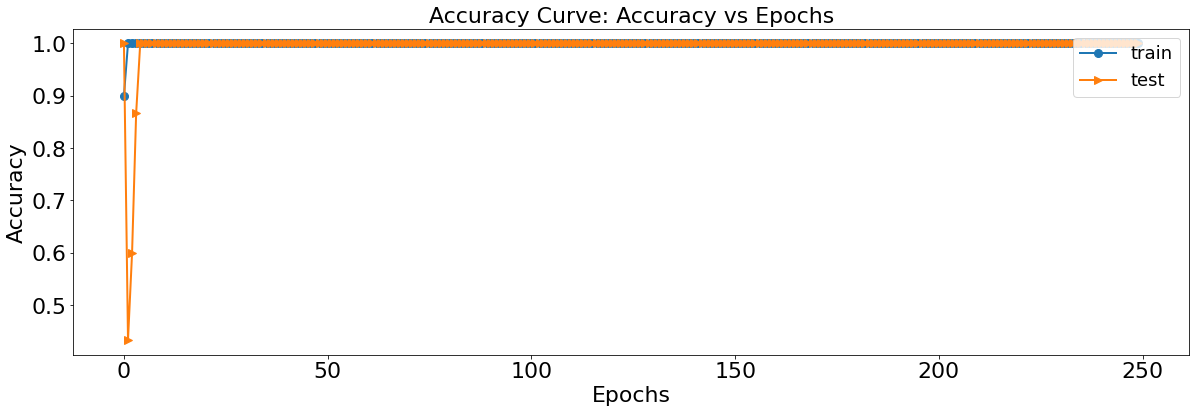

In [22]:
# Summarize history for ACC
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.plot(history1.history['acc'],'-o',linewidth=2, markersize=8)
plt.plot(history1.history['val_acc'],'->',linewidth=2, markersize=8)
plt.title('Accuracy Curve: Accuracy vs Epochs',fontsize=22)
plt.ylabel('Accuracy',fontsize=22)
#plt.grid()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Epochs',fontsize=22)
plt.legend(['train', 'test'], loc='upper right',fontsize=18)
#plt.axis([0,200,0,100])
plt.savefig("acc.jpg", dpi=600)
plt.show()

In [ ]:
from sklearn.utils.multiclass import unique_labels
import itertools
import matplotlib.pyplot as plt
from keras.utils import to_categorical

fig = plt.gcf()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i,j],
      horizontalalignment = 'center',
      color = "white" if cm[i,j] > thresh else "black")

    fig.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import confusion_matrix

y_predict = model.predict([testImagesX1,testImagesX2], verbose = 2)
y_predict = np.argmax(y_predict, axis=1)

y_act = np.argmax(testY1, axis=1)  # converting one hot representation back to numerical data

cm = confusion_matrix(y_act, y_predict)

In [ ]:
# Plot Non-Normalized confusion matrix
cm_labels = ['uni','cross','quasi']
plot_confusion_matrix(cm, classes=cm_labels, title='Confusion matrix')

### Testing on new materials uni-laminate

In [ ]:
# input images from three different folders
pathA0 = 'E:/PhD-MSR/material_characterization_forJournal/DispersionCalculatorCode/PropagationAngleProfiler_2/store/PolarPlots/NewMaterials/uni/A0'
pathS0 = 'E:/PhD-MSR/material_characterization_forJournal/DispersionCalculatorCode/PropagationAngleProfiler_2/store/PolarPlots/NewMaterials/uni/S0'

In [ ]:
# import labels
LabelPath = 'E:/PhD-MSR/material_characterization_forJournal/DispersionCalculatorCode/PropagationAngleProfiler_2/store/Dataset/NewMaterials/Labels_NewMaterials2.txt'
df = pd.read_csv(LabelPath, header=None)
df.shape

In [ ]:
rho = df.iloc[:,0:1]/100     # in (g/cm3)/10
E1 = df.iloc[:,1:2]*1e-9     # in GPa
E2 = df.iloc[:,2:3]*1e-9     # in GPa
G12 = df.iloc[:,3:4]*1e-9    # in GPa
v12 = df.iloc[:,4:5]*100     # in %
v23 = df.iloc[:,5:6]*100     # in %

dfn = pd.concat([rho,E1,E2,G12,v12,v23],axis=1)
dfm = np.array(dfn)

In [ ]:
# load the images of A0, S0 and SH0
print("[INFO] loading A0 images...")
imagesA0 = load_A0_images(dfn, pathA0)
imagesA0 = imagesA0/225.0
print("[INFO] loading S0 images...")
imagesS0 = load_S0_images(dfn, pathS0)
imagesS0 = imagesS0/255.0
print("[INFO] loading SH0 images...")
imagesSH0 = load_SH0_images(dfn, pathSH0)
imagesSH0 = imagesSH0/255.0
print("[INFO] Done...")

In [ ]:
from sklearn.metrics import confusion_matrix

y_predict2 = model.predict([imagesA0,imagesS0,imagesSH0], verbose = 2)
y_predict2 = np.argmax(y_predict2, axis=1)

y_act2 = np.zeros((4820,1), dtype=int)

#y_act2 = np.argmax(testY1, axis=1)  # converting one hot representation back to numerical data

cm = confusion_matrix(y_act2, y_predict2)

In [ ]:
# Plot Non-Normalized confusion matrix
cm_labels = ['uni','cross','quasi']
plot_confusion_matrix(cm, classes=cm_labels, title='Confusion matrix')